In [1]:
import msgpack
import pandas as pd

* For each bracket...
* Find the best score at each decision point

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

In [3]:
pd.__version__

'0.23.0'

In [4]:
# from sklearn.datasets import make_circles
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
# X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
# X2[:, 0] += 0.6
# X_info = np.concatenate((X1, X2))
# y = np.concatenate((y1, y2 + 2))

# df = pd.DataFrame(X_info)
# df["y"] = y
# ax = df.plot.scatter(x=0, y=1, c="y", cmap="tab10", vmax=10, alpha=0.03)
# # ax.yaxis.set_major_locator(plt.NullLocator())
# # ax.xaxis.set_major_formatter(plt.NullFormatter())
# ax.set_ylabel("")
# plt.savefig("figs/synthetic-dataset.png", dpi=300, bbox_inches="tight")

In [5]:
today = "2019-06-22-more-aggressive"
today = "2019-07-06"

def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
    
with open(f"out/{today}-histories-2.msgpack", "rb") as f:
    histories = msgpack.load(f)

histories = _to_str_keys(histories)

In [6]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [7]:
hyperband_params = [
    tuple({k: v for k, v in h["params"].items() if "hidden" not in k}.items())
    for hist in histories["hyperband"]
    for h in hist
]
passive_params = [
    tuple({k: v for k, v in h["params"].items() if "hidden" not in k}.items())
    for hist in histories["passive"]
    for h in hist
]


hyperband_params = {h for h in hyperband_params}
passive_params = {h for h in passive_params}

same = hyperband_params.intersection(passive_params)
len(same), len(hyperband_params), len(same) / len(hyperband_params)

(500, 38178, 0.013096547750013097)

In [8]:
from sklearn.utils import check_random_state
def shape_history(history, **kwargs):
#     global hist_df
    scores = {}
    pf_calls = {}
    print(kwargs)
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    hist_df = pd.DataFrame(history)
    for _, row in hist_df.iterrows():
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [9]:
import pandas as pd

hists = [
    shape_history(hist, alg=alg, k=k)
    for alg, hists in histories.items()
    for k, hist in enumerate(hists)
]

{'alg': 'hyperband', 'k': 0}
{'alg': 'hyperband', 'k': 1}
{'alg': 'hyperband', 'k': 2}
{'alg': 'hyperband', 'k': 3}
{'alg': 'hyperband', 'k': 4}


KeyboardInterrupt: 

In [11]:
import numpy as np
def smooth(df, div=10):
    col = "cumulative_partial_fit_calls"
    df[col] = (df[col] // div) * div
    return df
    
    return pd.DataFrame({"best_score": avg_score, "cumulative_partial_fit_calls": avg_calls, **summary})

raw_dfs = [pd.DataFrame(hist) for hist in hists]
print(sum(len(df) for df in raw_dfs))
dfs = [smooth(df, div=30) for df in raw_dfs]
df = pd.concat(dfs)
# print(df.alg.unique())
# print(df.cumulative_partial_fit_calls.describe())
# print(len(df))
# df.head()

166667


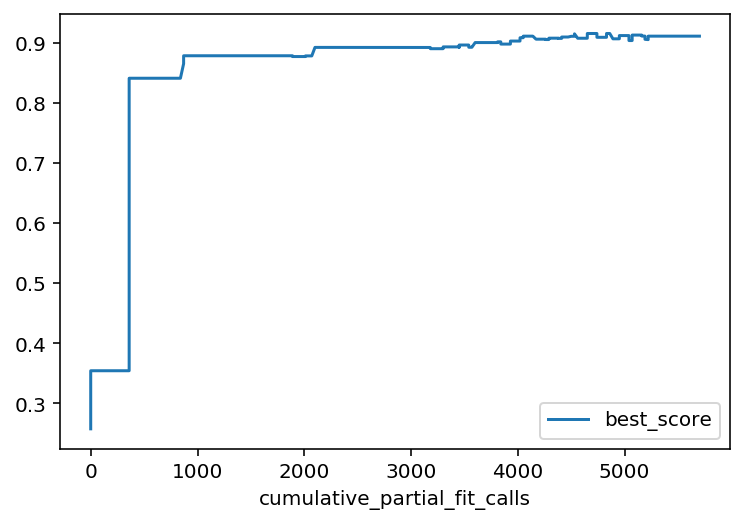

In [12]:
show = [df for df in raw_dfs 
        if df.loc[0, "alg"] == "hyperband"
        and df.loc[0, "random_state"] == 0]
show = show[0]

show.plot(x="cumulative_partial_fit_calls", y="best_score")

In [13]:
df.random_state.unique()

array([  0, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499])

In [32]:
import seaborn as sns

df["epochs"] = df["cumulative_partial_fit_calls"] / 3

kwargs = dict(
    index="epochs",
    values="best_score",
    columns="alg",
)

middle = df.pivot_table(aggfunc="mean", **kwargs)
lower = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.25), **kwargs)
upper = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.75), **kwargs)

In [33]:
middle.describe()

alg,hyperband,passive
count,191.000000,191.000000
mean,0.745280,0.762129
std,0.183039,0.123282
min,0.293189,0.288924
25%,0.624470,0.724243
50%,0.828333,0.811608
75%,0.899547,0.847626
max,0.907486,0.863105


passive
hyperband


Text(0.5, 0, 'Passes through dataset')

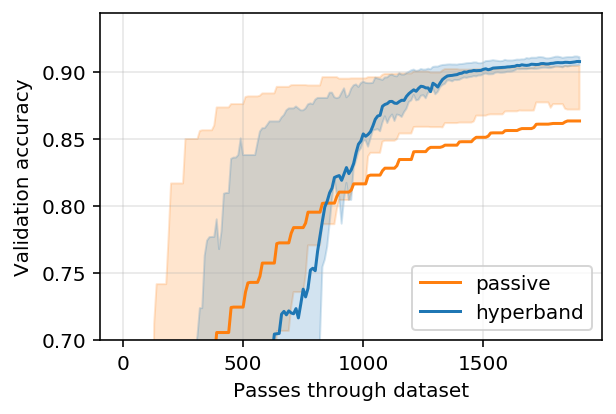

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    print(alg)
    show_mid = middle[alg].dropna()
    show_low = lower[alg].dropna()
    show_upp = upper[alg].dropna()
    
    show_mid.plot(ax=ax, color=colors[alg])
#     show_low.plot(ax=ax, color=colors[alg], style="--")
    col = "epochs"
    ax.fill_between(show_low.index, show_low.values, show_upp.values, alpha=0.20, color=colors[alg])
ax.set_ylim(0.70, None)
ax.legend(loc="lower right")
ax.grid(linestyle="-", alpha=0.3)
ax.set_ylabel("Validation accuracy")

ax.set_xlabel("Passes through dataset")
# plt.savefig("figs/synthetic-val-acc.pdf", bbox_inches="tight")

In [22]:
scores = pd.read_csv(f"out/{today}-best-scores.csv")
scores.columns

Index(['activation', 'alg', 'alpha', 'batch_size', 'hidden_layer_sizes',
       'learning_rate', 'learning_rate_init', 'momentum', 'n_iter_no_change',
       'nesterovs_momentum', 'power_t', 'random_state', 'score', 'solver'],
      dtype='object')

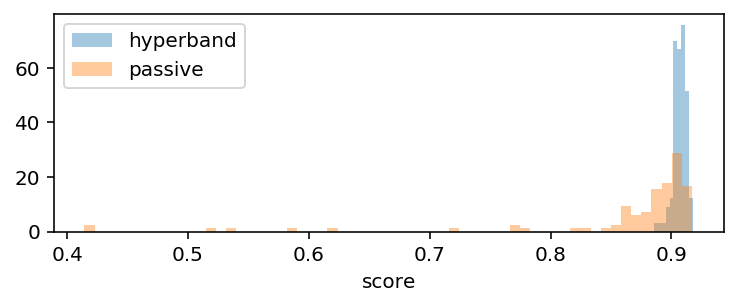

In [87]:
w = 2
fig, ax = plt.subplots(figsize=(3 * w, w))

bins = {"hyperband": 10, "passive": 60}

for alg in ["hyperband", "passive"]:
    show = scores[scores.alg == alg]
    sns.distplot(
        show.score,
        ax=ax,
        kde=False,
        label=alg,
        bins=bins[alg],
        norm_hist=True,
        vertical=False,
    )
# ax.set_ylim(None, 30)
ax.legend(loc="best")

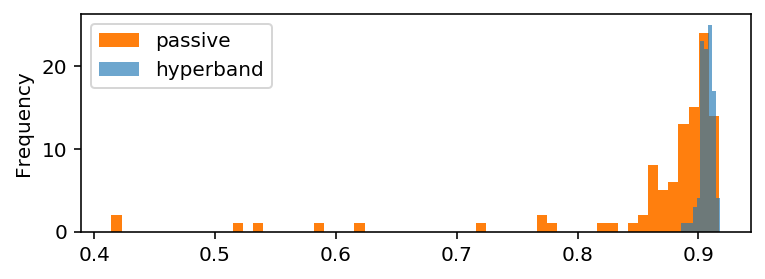

In [82]:
w = 2
fig, ax = plt.subplots(figsize=(3 * w, w))

bins = {"hyperband": 10, "passive": 60}

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    show = scores[scores.alg == alg]
    alpha = 0.65 if alg == "hyperband" else 1
    show.score.plot.hist(ax=ax, label=alg, bins=bins[alg],
                         color=colors[alg], alpha=alpha)
# ax.set_ylim(None, 30)
ax.legend(loc="best")

In [24]:
params = pd.read_csv(f"out/{today}-best-params.csv")

params[params.alg == "hyperband"]

,activation,alg,alpha,batch_size,best_score_,hidden_layer_sizes,learning_rate,learning_rate_init,momentum,n_iter_no_change,nesterovs_momentum,power_t,random_state,solver
0,relu,hyperband,0.000003,128,0.911348,"(12, 12)",constant,0.009036,0.876877,inf,True,0.868769,42,sgd
1,relu,hyperband,0.000025,256,0.904511,"(24,)",constant,0.004402,0.987988,inf,True,0.296196,42,sgd
2,relu,hyperband,0.000218,64,0.907150,"(12, 12)",constant,0.007869,0.830831,inf,True,0.515616,42,sgd
3,relu,hyperband,0.000012,256,0.913868,"(12, 12)",constant,0.007309,0.973974,inf,True,0.152052,42,sgd
4,relu,hyperband,0.000533,64,0.909549,"(12, 12)",constant,0.001340,0.925926,inf,True,0.843944,42,sgd
5,relu,hyperband,0.000023,32,0.885437,"(6, 6, 6, 6)",constant,0.008015,0.099099,inf,True,0.785485,42,sgd
6,relu,hyperband,0.000004,64,0.894554,"(6, 6, 6, 6)",constant,0.006544,0.835836,inf,True,0.774274,42,sgd
7,relu,hyperband,0.000020,32,0.910629,"(12, 12)",constant,0.000543,0.971972,inf,True,0.532432,42,sgd
8,relu,hyperband,0.000040,32,0.903191,"(12, 12)",constant,0.001002,0.970971,inf,True,0.114414,42,sgd
9,relu,hyperband,0.000835,128,0.909069,"(12, 12)",constant,0.000687,0.994995,inf,True,0.448348,42,sgd
